DQN

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from Model import Model
import gym
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt

# Parameters
use_cuda = True
episode_limit = 50
target_update_delay = 2  # update target net every target_update_delay episodes
test_delay = 10
learning_rate = 1e-4
epsilon = 1  # initial epsilon
min_epsilon = 0.1
epsilon_decay = 0.9 / 2.5e3
gamma = 0.99
memory_len = 10000

In [5]:
env = gym.make('CartPole-v1')
n_features = len(env.observation_space.high)
n_actions = env.action_space.n

memory = deque(maxlen=memory_len)
# each memory entry is in form: (state, action, env_reward, next_state)
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
policy_net = Model(n_features, n_actions).to(device)
target_net = Model(n_features, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


def get_states_tensor(sample, states_idx):
    sample_len = len(sample)
    states_tensor = torch.empty((sample_len, n_features), dtype=torch.float32, requires_grad=False)

    features_range = range(n_features)
    for i in range(sample_len):
        for j in features_range:
            states_tensor[i, j] = sample[i][states_idx][j].item()

    return states_tensor


def normalize_state(state):
    state[0] /= 2.5
    state[1] /= 2.5
    state[2] /= 0.3
    state[3] /= 0.3


def state_reward(state, env_reward):
    return env_reward - (abs(state[0]) + abs(state[2])) / 2.5


def get_action(state, e=min_epsilon):
    if random.random() < e:
        # explore
        action = random.randrange(0, n_actions)
    else:
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = policy_net(state).argmax().item()

    return action


def fit(model, inputs, labels):
    inputs = inputs.to(device)
    labels = labels.to(device)
    train_ds = TensorDataset(inputs, labels)
    train_dl = DataLoader(train_ds, batch_size=5)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    model.train()
    total_loss = 0.0

    for x, y in train_dl:
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    return total_loss / len(inputs)


def optimize_model(train_batch_size=100):
    train_batch_size = min(train_batch_size, len(memory))
    train_sample = random.sample(memory, train_batch_size)

    state = get_states_tensor(train_sample, 0)
    next_state = get_states_tensor(train_sample, 3)

    q_estimates = policy_net(state.to(device)).detach()
    next_state_q_estimates = target_net(next_state.to(device)).detach()

    for i in range(len(train_sample)):
        q_estimates[i][train_sample[i][1]] = (state_reward(next_state[i], train_sample[i][2]) +
                                              gamma * next_state_q_estimates[i].max())

    fit(policy_net, state, q_estimates)


def train_one_episode():
    global epsilon
    current_state = env.reset()
    normalize_state(current_state)
    done = False
    score = 0
    reward = 0
    while not done:
        action = get_action(current_state, epsilon)
        next_state, env_reward, done, _ = env.step(action)
        normalize_state(next_state)
        memory.append((current_state, action, env_reward, next_state))
        current_state = next_state
        score += env_reward
        reward += state_reward(next_state, env_reward)

        optimize_model(100)

        epsilon -= epsilon_decay

    return score, reward


def test():
    state = env.reset()
    normalize_state(state)
    done = False
    score = 0
    reward = 0
    while not done:
        action = get_action(state)
        state, env_reward, done, _ = env.step(action)
        normalize_state(state)
        score += env_reward
        reward += state_reward(state, env_reward)

    return score, reward


def main():
    best_test_reward = 0
    score_list=[]
    reward_list=[]

    for i in range(episode_limit):
        score, reward = train_one_episode()
        score_list.append(score)
        reward_list.append(reward)

        print(f'Episode {i + 1}: score: {score} - reward: {reward}')

        if i % target_update_delay == 0:
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()

        if (i + 1) % test_delay == 0:
            test_score, test_reward = test()
            print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
            if test_reward > best_test_reward:
                print('New best test reward. Saving model')
                best_test_reward = test_reward
                torch.save(policy_net.state_dict(), 'policy_net.pth')

    if episode_limit % test_delay != 0:
        test_score, test_reward = test()
        print(f'Test Episode {episode_limit}: test score: {test_score} - test reward: {test_reward}')
        if test_reward > best_test_reward:
            print('New best test reward. Saving model')
            best_test_reward = test_reward
            torch.save(policy_net.state_dict(), 'policy_net.pth')

    print(f'best test reward: {best_test_reward}')
    plt.plot(reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards over the episode')
    plt.title('Training Rewards over 100 Episodes')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    main()


TypeError: 'tuple' object does not support item assignment

Doble-DQN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 1: score: 16.0 - reward: 14.542524002492426
Episode 2: score: 25.0 - reward: 22.870516188442704
Episode 3: score: 29.0 - reward: 26.087771011143925
Episode 4: score: 16.0 - reward: 14.46327452287078
Episode 5: score: 28.0 - reward: 25.897789471596486
Episode 6: score: 19.0 - reward: 17.187675685063002
Episode 7: score: 39.0 - reward: 34.540457845479246
Episode 8: score: 14.0 - reward: 12.157117458432912
Episode 9: score: 23.0 - reward: 19.384567722678185
Episode 10: score: 57.0 - reward: 53.226602403074516
Test Episode 10: test score: 47.0 - test reward: 39.282012814283355
New best test reward. Saving model
Episode 11: score: 25.0 - reward: 22.961596614122392
Episode 12: score: 29.0 - reward: 24.784483462572094
Episode 13: score: 55.0 - reward: 48.011102767288705
Episode 14: score: 22.0 - reward: 19.88204892352223
Episode 15: score: 79.0 - reward: 72.22151179797949
Episode 16: score: 22.0 - reward: 18.976293863356112
Episode 17: score: 30.0 - reward: 25.744251660257575
Episode 

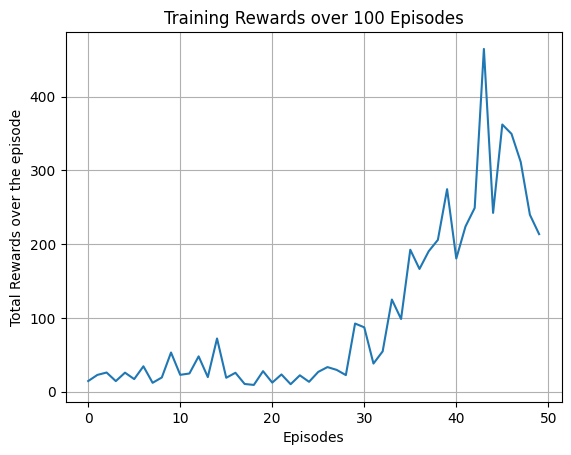

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from Model import Model
import gym
from collections import deque
import random

# Parameters
use_cuda = True
episode_limit = 50
target_update_delay = 2  # update target net every target_update_delay episodes
test_delay = 10
learning_rate = 1e-4
epsilon = 1  # initial epsilon
min_epsilon = 0.1
epsilon_decay = 0.9 / 2.5e3
gamma = 0.99
memory_len = 10000

env = gym.make('CartPole-v1')
n_features = len(env.observation_space.high)
n_actions = env.action_space.n

memory = deque(maxlen=memory_len)
# each memory entry is in form: (state, action, env_reward, next_state)
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
policy_net = Model(n_features, n_actions).to(device)
target_net = Model(n_features, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


def get_states_tensor(sample, states_idx):
    sample_len = len(sample)
    states_tensor = torch.empty((sample_len, n_features), dtype=torch.float32, requires_grad=False)

    features_range = range(n_features)
    for i in range(sample_len):
        for j in features_range:
            states_tensor[i, j] = sample[i][states_idx][j].item()

    return states_tensor


def normalize_state(state):
    state[0] /= 2.5
    state[1] /= 2.5
    state[2] /= 0.3
    state[3] /= 0.3


def state_reward(state, env_reward):
    return env_reward - (abs(state[0]) + abs(state[2])) / 2.5


def get_action(state, e=min_epsilon):
    if random.random() < e:
        # explore
        action = random.randrange(0, n_actions)
    else:
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = policy_net(state).argmax().item()

    return action


def fit(model, inputs, labels):
    inputs = inputs.to(device)
    labels = labels.to(device)
    train_ds = TensorDataset(inputs, labels)
    train_dl = DataLoader(train_ds, batch_size=5)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    model.train()
    total_loss = 0.0

    for x, y in train_dl:
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    return total_loss / len(inputs)


def optimize_model(train_batch_size=100):
    train_batch_size = min(train_batch_size, len(memory))
    train_sample = random.sample(memory, train_batch_size)

    state = get_states_tensor(train_sample, 0)
    next_state = get_states_tensor(train_sample, 3)

    q_estimates = policy_net(state.to(device)).detach()
    next_state_q_estimates = target_net(next_state.to(device)).detach()
    next_actions = policy_net(next_state.to(device)).argmax(dim=1)

    for i in range(len(train_sample)):
        next_action = next_actions[i].item()
        q_estimates[i][train_sample[i][1]] = (state_reward(next_state[i], train_sample[i][2]) +
                                              gamma * next_state_q_estimates[i][next_action].item())

    fit(policy_net, state, q_estimates)


def train_one_episode():
    global epsilon
    current_state = env.reset()
    normalize_state(current_state)
    done = False
    score = 0
    reward = 0
    while not done:
        action = get_action(current_state, epsilon)
        next_state, env_reward, done, _ = env.step(action)
        normalize_state(next_state)
        memory.append((current_state, action, env_reward, next_state))
        current_state = next_state
        score += env_reward
        reward += state_reward(next_state, env_reward)

        optimize_model(100)

        epsilon -= epsilon_decay

    return score, reward


def test():
    state = env.reset()
    normalize_state(state)
    done = False
    score = 0
    reward = 0
    while not done:
        action = get_action(state)
        state, env_reward, done, _ = env.step(action)
        normalize_state(state)
        score += env_reward
        reward += state_reward(state, env_reward)

    return score, reward


def main():
    best_test_reward = 0
    score_list_1=[]
    reward_list_1=[]

    for i in range(episode_limit):
        score, reward = train_one_episode()
        score_list_1.append(score)
        reward_list_1.append(reward)

        print(f'Episode {i + 1}: score: {score} - reward: {reward}')

        if i % target_update_delay == 0:
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()

        if (i + 1) % test_delay == 0:
            test_score, test_reward = test()
            print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
            if test_reward > best_test_reward:
                print('New best test reward. Saving model')
                best_test_reward = test_reward
                torch.save(policy_net.state_dict(), 'policy_net_1.pth')

    if episode_limit % test_delay != 0:
        test_score, test_reward = test()
        print(f'Test Episode {episode_limit}: test score: {test_score} - test reward: {test_reward}')
        if test_reward > best_test_reward:
            print('New best test reward. Saving model')
            best_test_reward = test_reward
            torch.save(policy_net.state_dict(), 'policy_net_1.pth')

    print(f'best test reward: {best_test_reward}')
    plt.plot(reward_list_1)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards over the episode')
    plt.title('Training Rewards over 100 Episodes')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    main()


Code for only running the saved models

In [ ]:
# import torch
# import gym
# import time
# from Train_DQN import normalize_state, state_reward
# from Model import Model
# env = gym.make('CartPole-v1')


# def main():
#     use_cuda = False
#     device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
#     policy_net = Model(len(env.observation_space.high), env.action_space.n)
#     policy_net.load_state_dict(torch.load('policy_net.pth'))
#     policy_net.to(device)
#     policy_net.eval()

#     state = env.reset()
#     normalize_state(state)
#     done = False
#     score = 0
#     reward = 0
#     while not done:
#         env.render()
#         state = torch.tensor(state, dtype=torch.float32)
#         action = torch.argmax(policy_net(state)).item()
#         state, env_reward, done, _ = env.step(action)
#         normalize_state(state)
#         score += env_reward
#         reward += state_reward(state, env_reward)

#         time.sleep(0.01)

#     print(f'score: {score} - reward: {reward}')


# if __name__ == '__main__':
#     main()
